In [2]:
### CREATION DES ECHANTILLONS DE REFERENCE

import time as cl
import random as rd
import numpy as np
import pickle

def GenPermutation(n):  # Création d'une permutation de [0,1,2, ..., n-1]
    L1 = list(range(n))
    L = []
    m = n
    for k in range(n):
        nouv = rd.randint(0,m-1)
        m -= 1
        L.append(L1.pop(nouv))
    return L
    

def PartitionHomogene(X,ident,p):   
# Utiliser la fonction VectorisationAmb pour avoir X et ident
    deb = 0
    nX = []
    nY = []
    nXn = []
    nYn = []
    n = 0
    for couple in ident:
        nbTextes = couple[1]
        TailleSample = int(nbTextes * p)
        L = GenPermutation(nbTextes)
        
        for k in range(TailleSample):
            nX.append(X[ deb+L[k] ])
            nY.append(n)
        
        
        for k in range(TailleSample,nbTextes):
            nXn.append(X[ deb + L[k] ])
            nYn.append(n)
        
        deb += nbTextes
        n+=1
    return nX, nY, nXn, nYn
    
    
def GenEchantillons(n,p,Xt,ident):
    Xtot = []        
    c1=cl.clock()
    
    for k in range(n):
        nX,nY,nXn,nYn = PartitionHomogene(Xt,ident,p)
        Xtot.append((nX,nY,nXn,nYn))
    c2=cl.clock()
    print(c2-c1)
        
    return Xtot
    
def GenGamme(n,pas):
    Interv = np.linspace(0,1,pas)

    Banque=[]
      
    response = VectorisationAmb()
    Vec,ident = response
    X = []
    for vec in Vec:
        X.append(list(vec))
    Y = []

    for k in range(len(ident)):
        for i in range(ident[k][1]):
            Y.append(k)
    dim = 30
    Xt,pca = ReductionDim(X,dim)
    xt = []
    for a in Xt:
        xt.append(list(a))
    Xt = xt
    
    for p in Interv[1:(pas-1)]:
        Banque.append(GenEchantillons(n,p,Xt,ident))
    
    
    return Banque
        

##Banque = GenGamme(20,11)


def moyenne(X):
    n = len(X)
    tot = 0
    for x in X:
        tot+=x
    moy = tot/n
    variance = 0
    for x in X:
        elem = (moy-x)**2
        variance += elem/n
    ecartType = variance*(1/2)
    incertitude = ecartType/(n**(1/2))
    return moy,incertitude
    
    

    
# Extraction d'un fichier binaire
def readbinary(adresse):
        
    with open(adresse, "rb") as file:
        s = file.read()
    return s
    
def register(Banque,direction):
    serialBanque = pickle.dumps(Banque)
    
    
    fichiertxt = open(direction,mode="xb")
    fichiertxt.write(serialBanque)
    fichiertxt.close()

def recuperation(direction):
    c1 = cl.clock()

    serial_Banque= readbinary(direction)
    
    Banque= pickle.loads(serial_Banque)
    c2 = cl.clock()
    print(c2-c1)
    return Banque


##Banque = recuperation("Banque")


In [3]:
DecisionTreeRes = recuperation("/Users/NAIT/classification/pact35/modules/Classification/src/DecisionTree/Résultats/DecisionTree")

0.001882999999999857


In [4]:
from sklearn import tree

def entraineDecisionTree(nX,nY):
    model = tree.DecisionTreeClassifier()
    model.fit(nX,nY)
    return model


def testDecisionTree(nX, nY, nXn, nYn):
    #nX et nY les parties d'entraînement
    #nXn et nYn les parties de test
    model = tree.DecisionTreeClassifier()
    model.fit(nX,nY)
    n = len(nXn)
    if n == 0:
        return -1
    goal = 0
    failure = 0
    
    for k in range(n):
        prediction = model.predict([nXn[k]])
        if prediction[0] == nYn[k]:
            goal+=1
        else:
            failure +=1
    return goal/n

    
def efficDecisionTree(Banque):
    P = np.linspace(0,1,11)
    P = P[1:10]    # On enlève les cas triviaux 0 et 1
    res = []
    OrdonneeP = []
    for i in range(len(P)):
        c1 = cl.clock()
        EnsemblePartitionP = Banque[i]
        p =P[i]
        Z = []
        
        for (nX, nY, nXn, nYn) in EnsemblePartitionP:
            zi = testDecisionTree(nX, nY, nXn, nYn)
            Z.append(zi)
        z,incertitude = moyenne(Z)
        OrdonneeP.append((z,incertitude))
        c2 = cl.clock()
        print("Pour la proportion p = ", p , ", on met un temps de ", (c2-c1) ," secondes")
    return P,OrdonneeP


##PTree=np.array([ 0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9])

##OrdTree=[(0.1370941020543406, 8.478092134235595e-06), (0.1492921013412817, 5.737876298203677e-06), (0.15767758400680565, 4.703177661247316e-06), (0.15815972222222224, 5.087160613272052e-06), (0.1620453190220632, 6.805513986774755e-06), (0.16005192878338279, 9.2653994092179e-06), (0.15526057030481807, 4.398461455379801e-06), (0.16022058823529406, 6.104576801678846e-06), (0.15942857142857142, 4.797050322342406e-05)]


### La fonction retourne une liste, notée NaiveBayesRes, qui est une liste de couples comportant le taux de réussite et un calcul d'incertitude; et ce pour chaque proportion p du DataTraining. À noter que ce classifieur ne nécessite pas de paramètre en entrée. 

In [5]:
DecisionTreeRes = [(0.1370941020543406, 8.478092134235595e-06), (0.1492921013412817, 5.737876298203677e-06), (0.15767758400680565, 4.703177661247316e-06), (0.15815972222222224, 5.087160613272052e-06), (0.1620453190220632, 6.805513986774755e-06), (0.16005192878338279, 9.2653994092179e-06), (0.15526057030481807, 4.398461455379801e-06), (0.16022058823529406, 6.104576801678846e-06), (0.15942857142857142, 4.797050322342406e-05)]

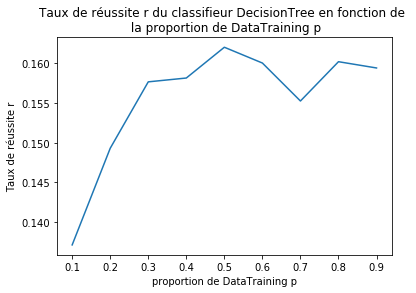

In [6]:
import numpy as np
import matplotlib.pyplot as plt

x = np.array([ 0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9])
y = np.array([DecisionTreeRes[i][0] for i in range(len(DecisionTreeRes))])


plt.plot(x, y)
plt.title("Taux de réussite r du classifieur DecisionTree en fonction de \n la proportion de DataTraining p")
plt.xlabel("proportion de DataTraining p")
plt.ylabel("Taux de réussite r")
plt.savefig('CourbeDecisionTreethiz.png')
plt.show() # affiche la figure a l'ecran


## Détermination du maximum d'efficacité du DecisionTree et des paramètres associés

In [14]:
max = 0
imax = 0
k = 0
for yi in y:
    k+=1
    if yi>max:
        max = yi
        imax = k
print ("Efficacité maximale du classifieur par DecisionTree = " + str(max*100) + "%")
print("obtenue pour une proportion de DataTraining p = " + str(imax*0.1))

Efficacité maximale du classifieur par DecisionTree = 16.2045319022%
obtenue pour une proportion de DataTraining p = 0.5


## CONCLUSION : Éfficacité du classifieur DecisionTree maximale, de maximum 16.2% de réussite avec une proportion de DataTraining p= 0.5

### NB : À noter qu'on considère être une réussite le fait de renvoyer exactement l'ambiance du texte. Les rapprochements d'ambiance ne sont pas pris en compte. Notamment, on ne pondère pas selon si la deuxième ambiance trouvée se rapproche de celle souhaitée.